## BERT tutorial: Classify spam vs no spam emails

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

<h4>Import the dataset (Dataset is taken from kaggle)</h4>

In [2]:
import pandas as pd

df = pd.read_csv("data/spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [4]:
df['spam']=df['Category'].apply(lambda x: 1 if x=='spam' else 0)
df.head()

,Category,Message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [5]:
df_spam = df[df['Category'] == 'spam']
df_ham = df[df['Category'] == 'ham']
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_balanced = pd.concat([df_spam,df_ham_downsampled])

In [6]:
df_balanced['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [7]:
df = df_balanced.copy()

<h4>Split it into training and test data set</h4>

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Message'],df['spam'], stratify=df['spam'])

In [9]:
X_train.head(4)

471     okmail: Dear Dave this is your final notice to...
4169    Congrats! Nokia 3650 video camera phone is you...
2427    Valentines Day Special! Win over £1000 in our ...
611     22 days to kick off! For Euro2004 U will be ke...
Name: Message, dtype: object

<h4>Now lets import BERT model and get embeding vectors for few sample statements</h4>

In [10]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [11]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351707, -0.5132727 , -0.8884575 , ..., -0.747489  ,
        -0.7531475 ,  0.91964495],
       [-0.8720837 , -0.5054398 , -0.94446695, ..., -0.8584751 ,
        -0.71745366,  0.88082975]], dtype=float32)>

<h4>Get embeding vectors for few sample words. Compare them using cosine similarity</h4>

In [12]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911089]], dtype=float32)

Values near to 1 means they are similar. 0 means they are very different.
Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits

In [14]:
cosine_similarity([e[0]],[e[3]])

array([[0.8470384]], dtype=float32)

Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes

In [15]:
cosine_similarity([e[3]],[e[4]])

array([[0.9872036]], dtype=float32)

Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above

<h4>Build Model</h4>

There are two types of models you can build in tensorflow. 

(1) Sequential
(2) Functional

So far we have built sequential model. But below we will build functional model. More information on these two is here: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057

In [16]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

https://stackoverflow.com/questions/47605558/importerror-failed-to-import-pydot-you-must-install-pydot-and-graphviz-for-py

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [18]:
len(X_train)

1120

In [19]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name = 'precision'),
    tf.keras.metrics.Recall(name='recall')
]

# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

<h4>Train the model</h4>

In [20]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
35/35 [==============================] - 26s 464ms/step - loss: 0.6170 - accuracy: 0.6830 - precision: 0.6764 - recall: 0.7018
Epoch 2/5
35/35 [==============================] - 16s 462ms/step - loss: 0.5101 - accuracy: 0.8116 - precision: 0.8056 - recall: 0.8214
Epoch 3/5
35/35 [==============================] - 16s 462ms/step - loss: 0.4450 - accuracy: 0.8366 - precision: 0.8301 - recall: 0.8464
Epoch 4/5
35/35 [==============================] - 16s 461ms/step - loss: 0.3991 - accuracy: 0.8741 - precision: 0.8682 - recall: 0.8821
Epoch 5/5
35/35 [==============================] - 16s 464ms/step - loss: 0.3662 - accuracy: 0.8839 - precision: 0.8669 - recall: 0.9071


In [21]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 7s 439ms/step - loss: 0.3433 - accuracy: 0.8984 - precision: 0.9357 - recall: 0.8556


[0.3432594835758209, 0.8983957171440125, 0.9356725215911865, 0.855614960193634]

In [22]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 6s 454ms/step


In [23]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,

In [24]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test,y_predicted)
cm

array([[176,  11],
       [ 27, 160]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

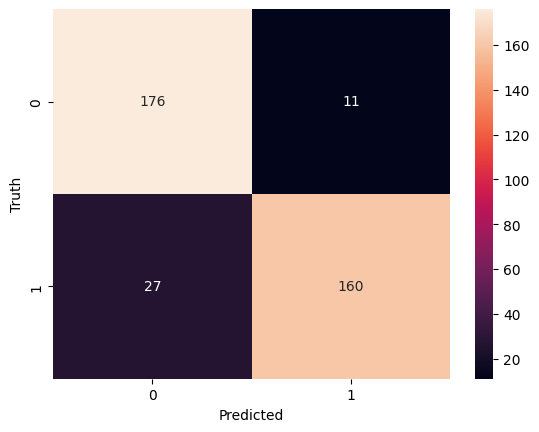

In [26]:
from matplotlib import pyplot as plt
import seaborn as sn

sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [27]:
print(classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       187
           1       0.94      0.86      0.89       187

    accuracy                           0.90       374
   macro avg       0.90      0.90      0.90       374
weighted avg       0.90      0.90      0.90       374



<h4>Inference</h4>

If output is >0.5 then spam otherwise not.

In [ ]:
reviews = [
    'Reply to win Â£100 weekly! Where will the 2006 FIFA World Cup be held? Send STOP to 87239 to end service',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

Homework: https://www.tensorflow.org/text/tutorials/classify_text_with_bert